# Prerequisites
To get the most out of this notebook you should be comfortable with the following concepts.
- Basics of working with text data (from the Day 4 Notebook)
- The Bag-of-Words model
- Basic classifiers (Logistic Regression, Decision Trees, Naive Bayes)

# Initial Setup

The first several cells here are setting up our ever-more-complex development environment for working with a new set of tools, moving to multilingual NLP with a set of more state-of-the-art methods, and downloading two different datasets for analysis. Much of the contents is duplicated from past notebooks.

**Run the first cell once and restart the runtime before running the rest of the notebook!**

In [ ]:
# You are going to need to run this cell, restart the runtime after running this command,
# then start over before you can run the code in this notebook.
!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_md-2.2.0/en_core_web_md-2.2.0.tar.gz


     |████████████████████████████████| 96.4 MB 106 kB/s 


**Import our Libraries**


In [ ]:
# Make our Imports
import math
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import dates
from datetime import datetime
import re
import calendar
import json

from sklearn.metrics import accuracy_score, precision_score, recall_score, cohen_kappa_score, confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, GaussianNB, MultinomialNB 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import spacy
from spacy.lang.en import English
from spacy.lang.zh import Chinese

import jieba

import sklearn
estimators = sklearn.utils.all_estimators(type_filter=None)
for name, class_ in estimators:
    if hasattr(class_, 'predict_proba'):
        print(name)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


AdaBoostClassifier
BaggingClassifier
BayesianGaussianMixture
BernoulliNB
CalibratedClassifierCV
CategoricalNB
ClassifierChain
ComplementNB
DecisionTreeClassifier
DummyClassifier
ExtraTreeClassifier
ExtraTreesClassifier
GaussianMixture
GaussianNB
GaussianProcessClassifier
GradientBoostingClassifier
GridSearchCV
HalvingGridSearchCV
HalvingRandomSearchCV
HistGradientBoostingClassifier
KNeighborsClassifier
LabelPropagation
LabelSpreading
LinearDiscriminantAnalysis
LogisticRegression
LogisticRegressionCV
MLPClassifier
MultiOutputClassifier
MultinomialNB
NuSVC
OneVsRestClassifier
Pipeline
QuadraticDiscriminantAnalysis
RFE
RFECV
RadiusNeighborsClassifier
RandomForestClassifier
RandomizedSearchCV
SGDClassifier
SVC
SelfTrainingClassifier
StackingClassifier
VotingClassifier


**Download our Datasets**

In [ ]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp' -O alexa_train.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1VYfti_C9WuF9moYKf73yV6IQwK-zZbdL' -O weibo.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1amPW_B1Lr5cnmArs31d2RKTMuKXRSaoE' -O stopwords-zh.txt

--2022-04-18 03:30:28--  https://drive.google.com/uc?export=download&id=1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp
Resolving drive.google.com (drive.google.com)... 74.125.31.101, 74.125.31.138, 74.125.31.139, ...
Connecting to drive.google.com (drive.google.com)|74.125.31.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h9c61u6kjn32obb2d9uhulcqub2ndgou/1650252600000/09640029349513786515/*/1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp?e=download [following]
--2022-04-18 03:30:30--  https://doc-0s-b0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/h9c61u6kjn32obb2d9uhulcqub2ndgou/1650252600000/09640029349513786515/*/1FJ5Jp5TgpMV1cP0CX0Z1hszSNsiEWDhp?e=download
Resolving doc-0s-b0-docs.googleusercontent.com (doc-0s-b0-docs.googleusercontent.com)... 172.217.193.132, 2607:f8b0:400c:c03::84
Connecting to doc-0s-b0-docs.googleusercontent.com (doc-0s-b0-docs.go

**Bring in functions from other Notebooks**

This allows us to easily compare different classifiers we train

In [ ]:
"""
Options for noisy: "loud", "quiet", and other. Any other value prints nothing (silent).
"""

# Start by defining a function to evaluate a classifier's predictions
def evaluate(y_pred, y_actual, metrics, model_name = 'model'):
    # Compute Confusion Matrix
    conf_matrix = confusion_matrix(y_actual, y_pred)

    # Compute and store each metric
    model_metrics = {}
    for (metric_name, metric) in metrics.items():
        result = metric(y_actual, y_pred)
        model_metrics[metric_name] = result

    return conf_matrix, model_metrics

# Then define a function that trains a classifier and evaluates it on one fold
def evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy = 'loud', labels=[]):

    # Train and Evaluate Model
    model = classifier.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = classifier_name)

    # Display Results appropriately when noisy is set to 'loud' or 'quiet'
    if noisy == 'quiet' and fold_num == 0:
        print(f"{classifier_name}: Fold {fold_num}", end = '')
    elif noisy == 'quiet':
        print(f'...{fold_num}', end ='')
    elif noisy == 'loud':
        print(f"{classifier_name}: Fold {fold_num} Results")
        ConfusionMatrixDisplay(conf_matrix, labels).plot(values_format='.4g')
        plt.show()
        print(model_metrics)
        print("------------------------")

    return model_metrics

# Then define a function to evaluate over all folds
def evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = 'loud', labels=[]):

    # Initialize tracking variables
    all_fold_metrics = {metric_name: [] for metric_name in metrics}

    # Iterate over each fold
    for fold_num, (train_index, test_index) in enumerate(kf.split(X, y)):
        # Get the data subset for the current fold
        X_train = X.iloc[train_index]
        X_test = X.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]

        # Train and Evaluate the Model
        model_metrics =  evaluate_one_fold(classifier_name, classifier, X_train, y_train, X_test, y_test, metrics, fold_num, noisy, labels=labels)

        # Update our tracking variables
        [all_fold_metrics[metric_name].append(metric_val) for metric_name, metric_val in model_metrics.items()]

    return all_fold_metrics

#Dont worry about these two lines

# Then define a function to compare different classifiers
def compare_classifiers(classifiers, metrics, metric_to_optimize, df, feature_set,
                        target, folds = 10, shuffle = True, noisy='loud', labels=[]):
    # Initialize tracking variables
    best = 0
    best_name = None
    classifier_comparison = {}

    # Set up dataset and cross validation
    X = df.loc[:, feature_set]
    X = pd.get_dummies(X)
    y = df[target]
    kf = StratifiedKFold(n_splits=folds, shuffle=shuffle, random_state=123)


    # For each classifier
    for classifier_name, classifier in classifiers.items():
        # Evaluate on all metrics for all folds
        all_fold_metrics = evaluate_all_folds(classifier_name, classifier, X, y, kf, metrics, noisy = noisy, labels=labels)

        # Compute average performance on metric to optimize over
        optimization_metric_avg = np.mean(all_fold_metrics[metric_to_optimize])

        # Update Tracking Variables
        if optimization_metric_avg > best:
            best = optimization_metric_avg
            best_name = classifier_name
        classifier_comparison[classifier_name] = all_fold_metrics
        if noisy == 'quiet': 
            print()
            print(f"Average {metric_to_optimize}: {optimization_metric_avg:.3f}")
            print('-------------')
    # Return our results
    return best, best_name, classifier_comparison
    

**Prepare the Data**
- Load data with pandas
- Reduce the dataset size, and remove incomplete entries
- Create our simpler output labels we want to classify
- Preview our modified data

In [ ]:
filename = "alexa_train.csv"
df = pd.read_csv(filename)
df = df.drop('Unnamed: 0', axis=1)
df = df.dropna()
df = df.loc[df.conv_id % 10 == 0].copy()
df = df.reset_index()

# This creates a binary rating task instead of a more complex 5-label scale.
def simplify_rating(label):
  if label == "Excellent" or label == "Good":
    return "Positive"
  else:
    return "Neutral/Negative"

# This will produce a 4-label multiclass task, shrinking down from the eight labels 
# originally provided to us in the dataset.
def simplify_sentiment(label):
  if label in ["Sad", "Disgusted", "Fearful", "Angry"]:
      return "Negative"
  elif label in ["Happy", "Surprised"]:
      return "Positive"
  else:
      return label

df["rating_simple"] = df["turn_rating"].apply(simplify_rating)
df["sentiment_simple"] = df["sentiment"].apply(simplify_sentiment)
df

,index,conv_id,url,conf,message,agent,sentiment,source,turn_rating,agent_1_rating,agent_2_rating,rating_simple,sentiment_simple
0,191,100010,https://www.washingtonpost.com/lifestyle/style...,B,"Naming a cloned cat ""copy cat"", that's cute.",agent_1,Neutral,['FS3'],Excellent,Excellent,Good,Positive,Neutral
1,192,100010,https://www.washingtonpost.com/lifestyle/style...,B,You must have ESP. I was going to tell you teh...,agent_2,Sad,['FS3'],Good,Excellent,Good,Positive,Negative
2,193,100010,https://www.washingtonpost.com/lifestyle/style...,B,Really? That's awful to hear!,agent_1,Surprised,['FS2'],Poor,Excellent,Good,Neutral/Negative,Positive
3,194,100010,https://www.washingtonpost.com/lifestyle/style...,B,Of Roosevelt's 20 pets two were a bear and hyena!,agent_2,Surprised,['FS3'],Passable,Excellent,Good,Neutral/Negative,Positive
4,195,100010,https://www.washingtonpost.com/lifestyle/style...,B,"Whoa, cool! I know he seemed to be quite the a...",agent_1,Surprised,['Personal Knowledge'],Poor,Excellent,Good,Neutral/Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,188192,108620,http://www.washingtonpost.com/education/2018/0...,B,I just heard about it recently. I did see him...,agent_2,Neutral,['FS1'],Excellent,Excellent,Excellent,Positive,Neutral
18610,188193,108620,http://www.washingtonpost.com/education/2018/0...,B,"Did someone walk a mile in someone's 5,000 yea...",agent_1,Surprised,['FS1'],Excellent,Excellent,Excellent,Positive,Positive
18611,188194,108620,http://www.washingtonpost.com/education/2018/0...,B,"Yes, that's right. Years ago, shoes were more...",agent_2,Neutral,['FS1'],Excellent,Excellent,Excellent,Positive,Neutral
18612,188195,108620,http://www.washingtonpost.com/education/2018/0...,B,Fashion for sure and the prices for some are c...,agent_1,Surprised,['FS1'],Excellent,Excellent,Excellent,Positive,Positive


# More Classical NLP!

We're going to introduce three final ways of thinking about how to represent text:
   - Part-of-Speech Tagging
   - Dependency Parsing
   - Embedding Vectors

For each of them, we'll show how you can represent individual sentences in many different ways, each of which captures a different nuance about language.



## Establishing a Baseline

First we'll go back and re-run our unigram baseline to remember our performance on this data when all we had was surface features. This is a duplication of our results from yesterday. As a reminder, this was using unigrams for the BOW model in combination with a Naive Bayes classifier!

In [ ]:
def ngrams(column, vocab_size = 1000, min_n=1, max_n=1):
  vectorizer = CountVectorizer(max_features=vocab_size, ngram_range=(1,max_n))
  X = vectorizer.fit_transform(column)

  bow_df = pd.DataFrame(X.toarray())
  column_names = [str(i) for i in range(vocab_size)]
  for k, v in vectorizer.vocabulary_.items():
    column_names[v] = k
  bow_df.columns = column_names
  return column_names, bow_df

unigram_names, unigram_df = ngrams(df["message"], vocab_size = 1000, min_n=1, max_n=1)
unigram_df["rating"] = df["rating_simple"]
unigram_df["sentiment"] = df["sentiment_simple"]

unigram_df

,000,10,100,11,12,13,15,20,2000,2005,...,york,you,young,younger,your,yourself,youtube,zimbabwe,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18609,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18610,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive
18611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
18612,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Positive


In [ ]:
# Pick Classifiers to Compare
from sklearn.svm import LinearSVC, SVC
classifiers = {
    "Complement NB": ComplementNB(),
    "Linear SVM": LinearSVC(),
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
feature_set = unigram_names

sorted_sentiments = ["Curious to dive deeper", "Negative", "Neutral", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Linear SVM: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...4

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...5

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...6

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...7

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


...8...9
Average Kappa: 0.218
-------------
Best classifier is: Complement NB 
With K=0.238.


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


### Hyperparameter: N-Gram Length
Let's also tune our n-gram length like we did in the previous notebook!

In [ ]:
# DataFrame of Bigrams
bigram_names, bigram_df = ngrams(df["message"], vocab_size = 5000, max_n=2)
bigram_df["rating"] = df["rating_simple"]
bigram_df["sentiment"] = df["sentiment_simple"]


# DataFrame of Trigrams
trigram_names, trigram_df = ngrams(df["message"], vocab_size = 5000, max_n=3)
trigram_df["rating"] = df["rating_simple"]
trigram_df["sentiment"] = df["sentiment_simple"]
print(trigram_df.iloc[:5])

   000  000 per  000 per episode  000 year  000 years  10  10 episodes  \
0    0        0                0         0          0   0            0   
1    0        0                0         0          0   0            0   
2    0        0                0         0          0   0            0   
3    0        0                0         0          0   0            0   
4    0        0                0         0          0   0            0   

   10 people  10 years  100  ...  youtube  youtube is  yup  zealand  zimbabwe  \
0          0         0    0  ...        0           0    0        0         0   
1          0         0    0  ...        0           0    0        0         0   
2          0         0    0  ...        0           0    0        0         0   
3          0         0    0  ...        0           0    0        0         0   
4          0         0    0  ...        0           0    0        0         0   

   zimbabwe was  zimbabwe was called  zuckerberg            rating  

In [ ]:
### Setup classifiers and metrics to be used on all n-grams
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

### Compare classifiers on unigrams ###

best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Unigram classifier K={best:.3f}.")    

### Compare classifiers on bigrams ###

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, bigram_df, bigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Bigram classifier K={best:.3f}.")    

### Compare classifiers on trigrams ###

feature_set = list(trigram_df.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, trigram_df, trigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Trigram classifier K={best:.3f}.")    


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
Unigram classifier K=0.238.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.254
-------------
Bigram classifier K=0.254.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.253
-------------
Trigram classifier K=0.253.


### Hyperparameter: Stopwords, Case

On top of picking n for our n-grams, there are other ways we can preprocess the text for our BOW model. 

For example, we can make everything lowercase. This will lose case-sensitive features but will also help simplify our overall vocabulary of possible words.

There are also some words that are very common in the language. For example, "the" shows up in a large amount of sentences. Therefore, these words don't have much predictive power since they are in basically every text and we can just ignore them/remove them from our representation of the text. We call these extra common words **stopwords**.

In [ ]:
# Extract features for unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,1), stop_words='english')
X = vectorizer.fit_transform(df["message"])

no_stopwords_df = pd.DataFrame(X.toarray())
no_stopwords_columns = [str(i) for i in range(1000)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_columns[v] = k
no_stopwords_df.columns = no_stopwords_columns
no_stopwords_df["rating"] = df["rating_simple"]
no_stopwords_df["sentiment"] = df["sentiment_simple"]
no_stopwords_df.head()


,000,10,100,11,12,13,15,16,18,20,...,yellow,yep,yes,york,young,younger,youtube,zimbabwe,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive


In [ ]:
# Extract features for unigrams with case-sensitive features
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,1), lowercase=False)
X = vectorizer.fit_transform(df["message"])

case_sensitive_df = pd.DataFrame(X.toarray())
case_sensitive_columns = [str(i) for i in range(1000)]
for k, v in vectorizer.vocabulary_.items():
  case_sensitive_columns[v] = k
case_sensitive_df.columns = case_sensitive_columns
case_sensitive_df["rating"] = df["rating_simple"]
case_sensitive_df["sentiment"] = df["sentiment_simple"]
case_sensitive_df.head()


,000,10,100,11,12,13,15,20,212,30,...,year,years,yes,yet,you,young,your,youtube,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive


In [ ]:
unigram_df["rating"] = df["rating_simple"]
unigram_df["sentiment"] = df["sentiment_simple"]
unigram_df.head()

,000,10,100,11,12,13,15,20,2000,2005,...,york,you,young,younger,your,yourself,youtube,zimbabwe,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
1,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,Positive,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
3,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Neutral/Negative,Positive


In [ ]:

# Re-run our classifier with stopwords included, as a baseline (i.e., KEEP "THE").
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with stopwords K={best:.3f}.")    

# Then run our classifier on the feature space with stopwords removed (i.e., DROP "THE").
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, no_stopwords_df, no_stopwords_columns, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier without stopwords K={best:.3f}.")   

# Finally run our classifier on the feature space with case-sensitive unigrams (i.e., KEEP UPPER CASE WORDS AS UPPSER CASE).
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, case_sensitive_df, case_sensitive_columns, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with case-sensitive unigrams K={best:.3f}.")   


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
Classifier with stopwords K=0.238.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.195
-------------
Classifier without stopwords K=0.195.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.251
-------------
Classifier with case-sensitive unigrams K=0.251.


In [ ]:
# Since we did slightly better with case-sensitive unigrams, it's interesting to find out why.

unique_features = []
for feature in case_sensitive_columns:
  if feature not in unigram_names:
    unique_features.append(feature)
  
print(len(unique_features))
for feature in unique_features:
  print(feature)

167
Africa
Agreed
All
Also
Although
Amazon
America
American
And
Another
Anyway
Apparently
Are
As
At
Bart
Bill
Black
Brady
But
Can
Canada
Canadian
Christmas
Cool
Crazy
DC
DO
Did
Disney
Do
Earth
Eminem
Even
Everest
Exactly
Facebook
Floyd
For
Fox
France
George
Good
Google
Great
Ha
Haha
Have
He
Hello
Hey
Hi
His
House
How
Iceland
If
Im
In
Indonesia
Interesting
Internet
Is
Isn
It
Its
Iverson
JFK
Jackson
James
Japan
Jefferson
Jim
John
Jordan
Jupiter
Just
King
Korea
LOL
Lebron
Like
Linkin
Lol
Martin
Maybe
Me
Michael
Murray
My
NBA
NFL
Netflix
Nevada
New
News
Nice
Nike
No
North
Not
Now
Oh
On
One
Or
Park
People
Pink
Pokemon
President
Probably
QB
Really
Right
Roosevelt
Same
Seems
She
Simpsons
So
Some
Sometimes
Sounds
South
Speaking
Star
Stephen
TV
Thanks
That
Thats
The
Then
There
They
This
Those
Tim
Tom
True
Trump
Tupac
UK
US
Very
Wars
Washington
We
Well
What
When
White
Who
Why
Wonder
World
Would
Wow
Yea
Yeah
Yep
Yes
York
You
YouTube
Youtube


### Hyperparameter: Vocabulary Size
We can also tune how many words we store in our representations of the texts. Having a large vocabulary size means that we get more information about each document, but it also means that our dataframes will take up more room in memory and it will take more time to train our models!

In [ ]:
kappa_results = []
sizes_to_test = [50, 250, 500, 750, 1000, 1500, 2000, 2500]
for size in sizes_to_test:
  unigram_names, unigram_df = ngrams(df["message"], vocab_size = size, min_n=1, max_n=1)
  unigram_df["rating"] = df["rating_simple"]
  unigram_df["sentiment"] = df["sentiment_simple"]
  best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')
  print(f"At vocab size {size}, K={best:.3f}")
  kappa_results.append(best)


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.155
-------------
At vocab size 50, K=0.155
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.212
-------------
At vocab size 250, K=0.212
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.235
-------------
At vocab size 500, K=0.235
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.241
-------------
At vocab size 750, K=0.241
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
At vocab size 1000, K=0.238
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
At vocab size 1500, K=0.238
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.236
-------------
At vocab size 2000, K=0.236
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.234
-------------
At vocab size 2500, K=0.234


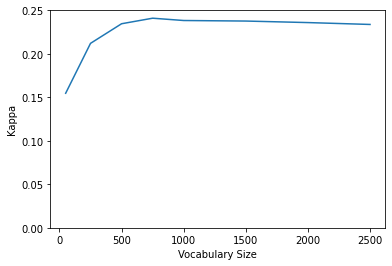

In [ ]:
plt.plot(sizes_to_test, kappa_results)
plt.ylim(0, 0.25)
plt.ylabel("Kappa")
plt.xlabel("Vocabulary Size")
plt.show()

In [ ]:
kappa_results = []
sizes_to_test = [50, 250, 500, 750, 1000, 1500, 2000, 2500]
for size in sizes_to_test:
  unigram_names, unigram_df = ngrams(df["message"], vocab_size = size, min_n=1, max_n=1)
  unigram_df["rating"] = df["rating_simple"]
  unigram_df["sentiment"] = df["sentiment_simple"]
  best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')
  print(f"At vocab size {size}, K={best:.3f}")
  kappa_results.append(best)

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.155
-------------
At vocab size 50, K=0.155
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.212
-------------
At vocab size 250, K=0.212
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.235
-------------
At vocab size 500, K=0.235
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.241
-------------
At vocab size 750, K=0.241
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
At vocab size 1000, K=0.238
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.238
-------------
At vocab size 1500, K=0.238
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.236
-------------
At vocab size 2000, K=0.236
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.234
-------------
At vocab size 2500, K=0.234


## Stemming

If we think about it, there are many words that have very similar meaning. It seems logical that we may want to treat those words the same when we train our models. For example, "dog" is probably about as similar to "dogs" as it is to just "dog" for many tasks. Stemming is one way to do this. We go through our sentence and simplify some common words before creating our ngrams and training a classifier. Here are some examples of some stemming:

am, are, is $\Rightarrow$ be 

car, cars, car's, cars' $\Rightarrow$ car

[More on Stemming](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)

In [ ]:
# First we're going to shrink our dataset down again so that parsing and POS tagging run in reasonable
# time while we're all in class. If you're willing to wait a few minutes to get tags for the whole
# dataset, you can skip these lines.

df = df.loc[df.conv_id % 50 == 0].copy()
df = df.reset_index()
df = df.drop("level_0", axis=1).drop("index", axis=1)
df

,conv_id,url,conf,message,agent,sentiment,source,turn_rating,agent_1_rating,agent_2_rating,rating_simple,sentiment_simple
0,100050,https://www.washingtonpost.com/local/virginia-...,D,What did you think of the last couple elections?,agent_1,Curious to dive deeper,['FS2'],Excellent,Excellent,Excellent,Positive,Curious to dive deeper
1,100050,https://www.washingtonpost.com/local/virginia-...,D,I think it has been great for the country. peo...,agent_2,Neutral,['FS2'],Excellent,Excellent,Excellent,Positive,Neutral
2,100050,https://www.washingtonpost.com/local/virginia-...,D,That is a great point. I want to keep seeing m...,agent_1,Curious to dive deeper,['FS2'],Excellent,Excellent,Excellent,Positive,Curious to dive deeper
3,100050,https://www.washingtonpost.com/local/virginia-...,D,the vote should be mandatory. then people woul...,agent_2,Neutral,"['FS2', 'Personal Knowledge']",Excellent,Excellent,Excellent,Positive,Neutral
4,100050,https://www.washingtonpost.com/local/virginia-...,D,"I agree, I am sure other countries do that. I ...",agent_1,Curious to dive deeper,['FS2'],Excellent,Excellent,Excellent,Positive,Curious to dive deeper
...,...,...,...,...,...,...,...,...,...,...,...,...
3740,108600,https://www.washingtonpost.com/news/fancy-stat...,D,"Wow, I guess football wasnt that popular back ...",agent_1,Curious to dive deeper,['FS3'],Excellent,Good,Good,Positive,Curious to dive deeper
3741,108600,https://www.washingtonpost.com/news/fancy-stat...,D,The guy must have had incredible hands or spec...,agent_2,Neutral,['FS3'],Good,Good,Good,Positive,Neutral
3742,108600,https://www.washingtonpost.com/news/fancy-stat...,D,"I bet he was, probably worth a few points, did...",agent_1,Curious to dive deeper,['FS3'],Excellent,Good,Good,Positive,Curious to dive deeper
3743,108600,https://www.washingtonpost.com/news/fancy-stat...,D,I guess they're hoping to psych out the opposi...,agent_2,Neutral,['FS3'],Good,Good,Good,Positive,Neutral


In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.3 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import spacy

In [ ]:
# Compute STEMMING using Spacy
nlp = spacy.load('en_core_web_md', disable=["tagger", "parser", "ner"])

def tokenize(nlp, row):
    message = row["message"]
    ix = row["conv_id"]
    tokens = nlp(message)
    return tokens

%time all_stemmed = df.apply(lambda x: tokenize(nlp, x), axis=1)
all_stemmed

CPU times: user 475 ms, sys: 5.63 ms, total: 480 ms
Wall time: 479 ms


0       (What, did, you, think, of, the, last, couple,...
1       (I, think, it, has, been, great, for, the, cou...
2       (That, is, a, great, point, ., I, want, to, ke...
3       (the, vote, should, be, mandatory, ., then, pe...
4       (I, agree, ,, I, am, sure, other, countries, d...
                              ...                        
3740    (Wow, ,, I, guess, football, was, nt, that, po...
3741    (The, guy, must, have, had, incredible, hands,...
3742    (I, bet, he, was, ,, probably, worth, a, few, ...
3743    (I, guess, they, 're, hoping, to, psych, out, ...
3744               (Think, that, could, be, effective, .)
Length: 3745, dtype: object

In [ ]:
# Turn our list of stemmed tokens back into strings
stemmed_inputs = []
for stemmed_tokens in all_stemmed:
  stemmed_string = " ".join([token.lemma_ for token in stemmed_tokens])
  stemmed_inputs.append(stemmed_string)

# Lets see what this stemming transformation looks like!
for i in [0, 1]:
  for token in all_stemmed.iloc[i]:
    print(token.text.ljust(10), end='')
  print()
  for token in all_stemmed.iloc[i]:
    print(token.lemma_.ljust(10), end='')
  print()
  print('-----------------------------------------------')

What      did       you       think     of        the       last      couple    elections ?         
What      do        you       think     of        the       last      couple    election  ?         
-----------------------------------------------
I         think     it        has       been      great     for       the       country   .         people    have      come      to        realize   the       power     of        the       vote      .         
I         think     it        have      be        great     for       the       country   .         people    have      come      to        realize   the       power     of        the       vote      .         
-----------------------------------------------


In [ ]:
# Now let's create some new dataframes and try training models with stemmed inputs
unigram_names, unigram_df = ngrams(df["message"])
stemmed_names, stemmed_df = ngrams(stemmed_inputs)


unigram_df["rating"] = df["rating_simple"]
unigram_df["sentiment"] = df["sentiment_simple"]

stemmed_df["rating"] = df["rating_simple"]
stemmed_df["sentiment"] = df["sentiment_simple"]

In [ ]:
metric_to_optimize = 'Kappa'

# Re-run our classifier with stopwords included, as a baseline.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, unigram_df, unigram_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with surface unigrams K={best:.3f}.")    


# Finally run our classifier on the feature space with case-sensitive unigrams.
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, stemmed_df, stemmed_names, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with stemmed unigrams K={best:.3f}.")   


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.213
-------------
Classifier with surface unigrams K=0.213.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.207
-------------
Classifier with stemmed unigrams K=0.207.


## Part-of-Speech Tagging

So far, we have been working exclusively with Bag of Words models for our documents. One of the (several) problems with the BOW model is that we completely ignore the structure of our sentences and just note whether individual words or phrases are present. Part-of-Speech Tagging is one way we can reintroduce some of the properties of our words back to our model by combining our BOW features with features representing the syntactic use of those sentences and the structure of our sentence.


This section walks through examples for tagging texts with part-of-speech tags, then inspecting those tags to understand what they look like in real data. 

In [ ]:
# Compute POS tagging using Spacy
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])

def tokenize(nlp, row):
    message = row["message"]
    ix = row["conv_id"]
    tokens = nlp(message)
    return tokens

%time all_tagged = df.apply(lambda x: tokenize(nlp, x), axis=1)
df["tokenized"] = all_tagged

CPU times: user 16 s, sys: 93.2 ms, total: 16.1 s
Wall time: 16 s


In [ ]:
# Print the first 2 messages
print(df["tokenized"].iloc[0])
print(df["tokenized"].iloc[1])
print()

# As well as their POS tagging
for i in [0, 1]:
  for token in df["tokenized"].iloc[i]:
    print(token.text.ljust(10), end='')
  print()
  for token in df["tokenized"].iloc[i]:
    print(token.lemma_.ljust(10), end='')
  print()
  for token in df["tokenized"].iloc[i]:
    print(token.pos_.ljust(10), end='')
  print()
  for token in df["tokenized"].iloc[i]:
    print(token.tag_.ljust(10), end='')
  print("\n-------------------------------------------------------------------------------------------------")


What did you think of the last couple elections?
I think it has been great for the country. people have come to realize the power of the vote.

What      did       you       think     of        the       last      couple    elections ?         
what      do        -PRON-    think     of        the       last      couple    election  ?         
PRON      AUX       PRON      VERB      ADP       DET       ADJ       NOUN      NOUN      PUNCT     
WP        VBD       PRP       VB        IN        DT        JJ        NN        NNS       .         
-------------------------------------------------------------------------------------------------
I         think     it        has       been      great     for       the       country   .         people    have      come      to        realize   the       power     of        the       vote      .         
-PRON-    think     -PRON-    have      be        great     for       the       country   .         people    have      come      to        rea

### Classifying with POS Tag Features

Next we can evaluate our performance using syntactic POS features alone, without that surface representation. However, we have essentially completely thrown away any information on what words were in our review other than their part of speech. This means that every review that is composed of a noun, verb, and adjective looks exactly the same! This results in the following being identical:

- The product is AMAZING
- The product is HORRIBLE

Unsurprisingly, losing this much information degrades our performance!

In [ ]:
# Create a string of the POS features for each sentence
pos_strings = []
for row in df["tokenized"]:
    pos_strings.append(" ".join([token.tag_ for token in row]))

print("Example of POS Features")
print(pos_strings[0])
print()

# Get the bigram representation of the POS features
column_names, pos_df = ngrams(pos_strings, vocab_size = 500, min_n=2, max_n=2)

# Add our classification features
pos_df["rating"] = df["rating_simple"]
pos_df["sentiment"] = df["sentiment_simple"]

# Preview the dataframe
print("Preview POS bigram dataframe")
pos_df

Example of POS Features
WP VBD PRP VB IN DT JJ NN NNS .

Preview POS bigram dataframe


,_sp,_sp cc,_sp dt,_sp ex,_sp in,_sp jj,_sp nnp,_sp nns,_sp prp,_sp rb,...,wrb nns,wrb prp,wrb rb,wrb to,wrb vbd,wrb vbp,wrb vbz,xx,rating,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Curious to dive deeper
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Curious to dive deeper
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Curious to dive deeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Curious to dive deeper
3741,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral
3742,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Curious to dive deeper
3743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,Positive,Neutral


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
pos_features = column_names
feature_set = pos_features

sorted_sentiments = ["Curious to dive deeper", "Negative", "Neutral", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, pos_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")    


Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.189
-------------
Best classifier is: Complement NB 
With K=0.189.


### Combining Feature Spaces

By simply appending all of our POS features to our bag-of-words features, we can get a representation that is much larger and still very sparse, but that outperforms the unigrams alone. 

In [ ]:
unigram_names, unigram_df = ngrams(df["message"], vocab_size = 1000, min_n=1, max_n=1)
pos_bigram_names, pos_bigram_df = ngrams(pos_strings, vocab_size = 500, min_n=2, max_n=2)

combined_bigram_df = unigram_df.merge(pos_bigram_df, how="left", left_index=True, right_index=True)
combined_bigram_df["rating"] = df["rating_simple"]
combined_bigram_df["sentiment"] = df["sentiment_simple"]

pos_trigram_names, pos_trigram_df = ngrams(pos_strings, vocab_size = 500, min_n=2, max_n=3)

combined_trigram_df = unigram_df.merge(pos_trigram_df, how="left", left_index=True, right_index=True)
combined_trigram_df["rating"] = df["rating_simple"]
combined_trigram_df["sentiment"] = df["sentiment_simple"]



In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

sorted_sentiments = ["Curious to dive deeper", "Negative", "Neutral", "Positive"]

# Pick features to use
feature_set = list(combined_bigram_df.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, combined_bigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with Unigrams + POS Bigrams K={best:.3f}.")    

# Pick features to use
feature_set = list(combined_trigram_df.columns[:-2])

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, combined_trigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Classifier with Unigrams + POS Bigrams and Trigrams K={best:.3f}.")    



Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.244
-------------
Classifier with Unigrams + POS Bigrams K=0.244.
Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.237
-------------
Classifier with Unigrams + POS Bigrams and Trigrams K=0.237.


## Dependency Parsing

Another weakness that we saw with the BOW model was that we completely lose the relationship between the words in the sentence. Dependency Parsing allows us to (kind of) fix this issue. For example, we may want to use phrases such as “South Africa” as a single word instead of ‘South’ and ‘Africa’ as separate words. Dependency Parsing allows us to do this, because we can notice that "South" is an adjective describing the noun "Africa" so we can understand how words are linked together in sentences.

<img src="https://miro.medium.com/max/3052/1*f6e0uf5PX17pTceYU4rbCA.jpeg" width="600">

[You can read more about Part-of-Speech Tagging and Dependency Parsing here.](https://medium.com/greyatom/learning-pos-tagging-chunking-in-nlp-85f7f811a8cb)

[Here is another source on combining these "Classical" NLP techniques](https://medium.com/@ageitgey/natural-language-processing-is-fun-9a0bff37854e)

This section will walk through and inspect how we can use dependency parsing to get additional understanding about the structure and content of our texts. This is starting to get into slower, more advanced NLP, and so this is about as deep as we're going to go for the purposes of this class.

In [ ]:
parser = spacy.load('en_core_web_md', disable=["ner"])

def parse(nlp, row):
    message = row["message"]
    ix = row["conv_id"]
    tokens = nlp(message)
    return tokens

%time all_parses = df.apply(lambda x: parse(parser, x), axis=1)
df["parses"] = all_parses

CPU times: user 32.9 s, sys: 132 ms, total: 33 s
Wall time: 33 s


In [ ]:
from spacy import displacy

for parse in df["parses"][:5]:
    print(parse)
    for chunk in parse.noun_chunks:
        print(chunk)
    displacy.render(parse, style='dep', jupyter=True)
    print("---")

What did you think of the last couple elections?
What
you
the last couple elections


---
I think it has been great for the country. people have come to realize the power of the vote.
I
it
the country
people
the power
the vote


---
That is a great point. I want to keep seeing more and more voter turnout. It hasn't been more than 62.8 percent in 100 years
a great point
I
more and more voter turnout
It
more than 62.8 percent
100 years


---
the vote should be mandatory. then people would see the power of the ballot.
the vote
people
the power
the ballot


---
I agree, I am sure other countries do that. I don't think we should go back to how ancient athens did it, do you know how?
I
I
other countries
I
we
how ancient athens
it
you


---


# Multilingual NLP

Of course, English isn't the only language that there are NLP tools available for. You can find similar tools available for most widely spoken languages! Let's take a look at this by doing some sentiment analysis on posts from [weibo](https://en.wikipedia.org/wiki/Microblogging_in_China), a chinese microblogging site similar to Twitter. We will look at each of the posts and predict the emotion felt by the poster from the text! While normally its not recommended to train models on data that you do not understand -- because it is nearly impossible to catch common training mistakes -- we can all look at this as just an example of how we can extend the techniques we have used so far to other languages.

To start off, let's load and preview our dataset.

In [ ]:
filename = "stopwords-zh.txt"
zh_stopwords = open(filename).readlines()
zh_stopwords = [x.strip() for x in zh_stopwords]
print(zh_stopwords)

['一', '一些', '一何', '一切', '一则', '一方面', '一旦', '一来', '一样', '一般', '一转眼', '七', '万一', '三', '上', '上下', '下', '不', '不仅', '不但', '不光', '不单', '不只', '不外乎', '不如', '不妨', '不尽', '不尽然', '不得', '不怕', '不惟', '不成', '不拘', '不料', '不是', '不比', '不然', '不特', '不独', '不管', '不至于', '不若', '不论', '不过', '不问', '与', '与其', '与其说', '与否', '与此同时', '且', '且不说', '且说', '两者', '个', '个别', '中', '临', '为', '为了', '为什么', '为何', '为止', '为此', '为着', '乃', '乃至', '乃至于', '么', '之', '之一', '之所以', '之类', '乌乎', '乎', '乘', '九', '也', '也好', '也罢', '了', '二', '二来', '于', '于是', '于是乎', '云云', '云尔', '五', '些', '亦', '人', '人们', '人家', '什', '什么', '什么样', '今', '介于', '仍', '仍旧', '从', '从此', '从而', '他', '他人', '他们', '他们们', '以', '以上', '以为', '以便', '以免', '以及', '以故', '以期', '以来', '以至', '以至于', '以致', '们', '任', '任何', '任凭', '会', '似的', '但', '但凡', '但是', '何', '何以', '何况', '何处', '何时', '余外', '作为', '你', '你们', '使', '使得', '例如', '依', '依据', '依照', '便于', '俺', '俺们', '倘', '倘使', '倘或', '倘然', '倘若', '借', '借傥然', '假使', '假如', '假若', '做', '像', '儿', '先不先', '光是', '全体', '全部', '八', '六', '兮', '共', '关于', '关于具体地说', '其', '其

In [ ]:
filename = "weibo.csv"
zh_df = pd.read_csv(open(filename))
zh_df = zh_df.drop('Unnamed: 0', axis=1)
zh_df["post"] = [x.replace("\n","") for x in zh_df["post"]]
zh_df["reply"] = [x.replace("\n","") for x in zh_df["reply"]]
print(f"Original shape: {zh_df.shape}")
zh_df = zh_df.loc[zh_df.index % 50 == 0].copy()
print(f"Reduced-size shape: {zh_df.shape}")

print(zh_df["post_emotion"].value_counts())
print(zh_df["reply_emotion"].value_counts())
zh_df

Original shape: (663621, 4)
Reduced-size shape: (13273, 4)
Like         4491
Disgust      3135
Sadness      2193
Happiness    2064
Anger        1390
Name: post_emotion, dtype: int64
Like         2974
Happiness    2948
Disgust      2765
Sadness      2604
Anger        1982
Name: reply_emotion, dtype: int64


,post,post_emotion,reply,reply_emotion
0,哈哈 、 生日 快乐 。 我 地 居然 同一 日 生日,Happiness,哈哈 … 生日 快乐 。,Happiness
50,是 2 丁目 的 工作 证 照片 吗 ?,Disgust,可以 不要 爆 人家 的 历史 背景 吗 ？,Disgust
100,老板 娘 很 喜欢 摩托,Like,这个 只能 算 花边 新闻 ， 好 不好 ！ 吃 的 东西 怎么 样 ？,Disgust
150,笑 点 好 低 啊,Happiness,是 比不上 你 那个 家里 三缺一 不能 打牌 就 决定 再生 个 出来 的 构想 搞笑 雷...,Disgust
200,应该 是 酷毙 了 !,Like,不错 相当 酷 我 喜欢 。 嘿嘿 。,Like
...,...,...,...,...
663400,这 是 杂 啦 。 生 大气 了 。 别 生气 。,Disgust,哎 。 。 。 气死 我 了,Sadness
663450,哈哈 ， 现在 看到 方 舟子 ， 我 有 一 种 强烈 的 肖 传国 感 。,Happiness,这 句 话 传神 ， 当然 ， 方 粉 脑袋 上 过 环 ， 会 以为 你 有 暴力 倾向,Disgust
663500,不 带 宝贝 ， 老天 爷 也 不 高兴 了 吧,Sadness,老天 爷 真 棒 ！,Like
663550,厉害 ！ 果然 是 闪电 不断 。,Like,一 秒 闪 三四 下 ， 估计 机场 惨 了 ， 塔台 乱套 了 吧 ？,Sadness


**Once again, let's simplify our possibile sentiments to make classification simpler**

In [ ]:
def simplify_sentiment(emotion):
  if emotion in ["Like", "Happiness"]:
    return "Positive"
  elif emotion in ["Sadness", "Disgust", "Anger"]:
    return "Negative"
  else:
    return "Other"

zh_df["post_sentiment"] = zh_df["post_emotion"].apply(simplify_sentiment)
zh_df["reply_sentiment"] = zh_df["reply_emotion"].apply(simplify_sentiment)
zh_df = zh_df.reset_index()
print(zh_df["post_sentiment"].value_counts())
print(zh_df["reply_sentiment"].value_counts())

Negative    6718
Positive    6555
Name: post_sentiment, dtype: int64
Negative    7351
Positive    5922
Name: reply_sentiment, dtype: int64


### Predicting Sentiment of Posts

In [ ]:
# Notice we can use the same Spacy tools for Chinese as we did for English
chinese_nlp = Chinese()

sample_sentence = "新浪微博，是一个由新浪网推出，提供微博客的社交媒体网站。"

tokenized = chinese_nlp(sample_sentence)
for token in tokenized:
    print(token)

spaced = " ".join([x.text for x in tokenized])
print(spaced)

新浪
微博
，
是
一个
由
新浪网
推出
，
提供
微
博客
的
社交
媒体
网站
。
新浪 微博 ， 是 一个 由 新浪网 推出 ， 提供 微 博客 的 社交 媒体 网站 。


In [ ]:
for token in tokenized:
  if token.text not in zh_stopwords:
    print(token.text)
  else:
    print(f"-------  Skipping: {token.text}")

新浪
微博
，
-------  Skipping: 是
一个
-------  Skipping: 由
新浪网
推出
，
提供
微
博客
-------  Skipping: 的
社交
媒体
网站
。


In [ ]:
# Let's create BOW features for our posts

# Tokenize our posts using Spacy
segmented_posts = []
for post in zh_df["post"]:
    tokens = chinese_nlp(post)
    spaced = " ".join([x.text for x in tokens])
    segmented_posts.append(spaced)

# Get the unigrams from our posts and add our classification column
column_names, zh_unigram_df = ngrams(segmented_posts, vocab_size = 1000, min_n=1, max_n=1)
zh_unigram_df["sentiment"] = zh_df["post_sentiment"]

# Preview our new DataFrame
zh_unigram_df

,20,90,一下,一个,一会,一切,一定,一把,一样,一点,...,高调,高铁,魅力,鸭梨,麻将,麻烦,黑色,鼓励,鼻子,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
13269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
13270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
13271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
unigram_features = list(zh_unigram_df.columns[:-1])
feature_set = unigram_features

sorted_sentiments = ["Negative", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, zh_unigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.699
-------------


**We can predict the sentiment of the replies as well!**

In [ ]:
# Tokenize Replies
segmented_replies = []
for reply in zh_df["reply"]:
  tokens = chinese_nlp(reply)
  spaced = " ".join([x.text for x in tokens])
  segmented_replies.append(spaced)

# Prepare unigrams DataFrame
column_names, zh_unigram_df = ngrams(segmented_replies, vocab_size = 1000, min_n=1, max_n=1)
zh_unigram_df["sentiment"] = zh_df["reply_sentiment"]

# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
unigram_features = list(zh_unigram_df.columns[:-1])
feature_set = unigram_features

sorted_sentiments = ["Negative", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, zh_unigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.699
-------------
Best classifier is: Complement NB 
With K=0.699.


### Hyperparameter: N-Grams in Chinese

We can also use the same types of hyperparameters we used for english when we train models on Chinese text!

In [ ]:
# Tokenize Replies
segmented_replies = []
for reply in zh_df["reply"]:
  tokens = chinese_nlp(reply)
  spaced = " ".join([x.text for x in tokens])
  segmented_replies.append(spaced)

# Prepare ngrams DataFrame
column_names, zh_bigram_df = ngrams(segmented_replies, vocab_size = 5000, min_n=1, max_n=2)
zh_bigram_df["sentiment"] = zh_df["reply_sentiment"]

zh_bigram_df

,10,100,11,12,13,19,20,2011,2012,23,...,黄牛,黄色,黑暗,黑色,默契,默默,鼓励,鼻子,鼻涕,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
13269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
13270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
13271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative


In [ ]:

# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
bigram_features = list(zh_bigram_df.columns[:-1])
feature_set = bigram_features

sorted_sentiments = ["Negative", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, zh_bigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet')

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.722
-------------
Best classifier is: Complement NB 
With K=0.722.


### Hyperparameter: Stopwords in Chinese

In [ ]:
# Extract features for unigrams with no stopwords included.
vectorizer = CountVectorizer(max_features=1000, ngram_range=(1,1), stop_words=zh_stopwords)
X = vectorizer.fit_transform(segmented_replies)

no_stopwords_df = pd.DataFrame(X.toarray())
no_stopwords_columns = [str(i) for i in range(1000)]
for k, v in vectorizer.vocabulary_.items():
  no_stopwords_columns[v] = k
no_stopwords_df.columns = no_stopwords_columns
no_stopwords_df["sentiment"] = zh_df["post_sentiment"]


In [ ]:
no_stopwords_df

,10,20,一下,一个,一会,一向,一如既往,一定,一把,一点,...,骂人,骄傲,骗人,骗子,高中,高兴,麻烦,默默,鼓励,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
13269,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
13270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
13271,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
unigram_features = list(no_stopwords_df.columns[:-1])
feature_set = unigram_features

sorted_sentiments = ["Negative", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, no_stopwords_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.161
-------------
Best classifier is: Complement NB 
With K=0.161.


# Domain Transfer

Notice that in our multilingual example, the task of predicting sentiment on replies and posts seem quite related. For example, it seems reasonable that a model that is good at predicting the sentiment of a post may also be good at predicting the sentiment of its replies. This kind of training is called Domain Transfer or **Transfer Learning**. 

This technique can be very useful if you have only a small amount of data for the task that you care about, but a lot of data for some related (but slighlty different) task. It can also often save us time (and $$$) by allowing us to reutilize things that we have already trained for our new tasks! We will also see that it is possible to start training a model on one (large, but not as interesting) dataset and then finish its training on a different (small, but very interesting) dataset to achieve much better performance than would be possible with just the small dataset alone.

[Here is a resource on Domain Transfer for image recognition that thoroughly explains Transfer Learning](https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a)

## Baseline -- Training on both Posts and Replies

Let's start by training a model on both the posts and replies to set a baseline for what our performance could be!

In [ ]:
combined_content = segmented_posts + segmented_replies
column_names, combined_unigram_df = ngrams(combined_content, vocab_size = 1000, min_n=1, max_n=1)

combined_labels = list(zh_df["post_sentiment"]) + list(zh_df["reply_sentiment"])
combined_unigram_df["sentiment"] = combined_labels

In [ ]:
combined_unigram_df

,10,20,90,一下,一个,一些,一会,一切,一向,一定,...,骗子,高中,高兴,高铁,魅力,麻烦,黑色,鼓励,鼻子,sentiment
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
26542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative
26543,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Positive
26544,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Negative


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Complement NB": ComplementNB()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
unigram_features = list(combined_unigram_df.columns[:-2])
feature_set = unigram_features

sorted_sentiments = ["Negative", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, combined_unigram_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

Complement NB: Fold 0...1...2...3...4...5...6...7...8...9
Average Kappa: 0.595
-------------
Best classifier is: Complement NB 
With K=0.595.


## Training with Transfer Learning
Now lets see what happens when we train on posts and test on replies, or train on replies and test on posts. 


Train on posts, test on replies:


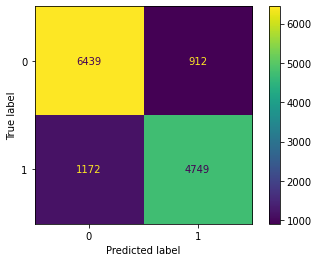

{'Accuracy': 84.29776974080771, 'Kappa': 0.6809039060580736}
------------------------


In [ ]:
posts_df = combined_unigram_df.iloc[:len(segmented_posts)]
replies_df = combined_unigram_df.iloc[len(segmented_posts)+1:]

# Train on posts, test on replies
X_train = posts_df.loc[:, feature_set]
X_train = pd.get_dummies(X_train)
y_train = posts_df["sentiment"]

X_test = replies_df.loc[:, feature_set]
X_test = pd.get_dummies(X_test)
y_test = replies_df["sentiment"]

classifier = ComplementNB()
# Train and Evaluate Model
model = classifier.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = "Naive Bayes")

print(f"Train on posts, test on replies:")
ConfusionMatrixDisplay(conf_matrix).plot(values_format='.4g')
plt.show()
print(model_metrics)
print("------------------------")


Training data using post messages are highly predictive of reply sentiments, given the model accuracy of 84%. Further, the model generated a cappa of 0.681, which is > the baseline model kappa of 0.595. THus, high confidence in this model. 

In [ ]:
# Train on replies, test on posts
X_train = replies_df.loc[:, feature_set]
X_train = pd.get_dummies(X_train)
y_train = replies_df["sentiment"]

X_test = posts_df.loc[:, feature_set]
X_test = pd.get_dummies(X_test)
y_test = posts_df["sentiment"]

classifier = ComplementNB()
# Train and Evaluate Model
model = classifier.fit(X_train, y_train)

y_pred = model.predict(X_test)
conf_matrix, model_metrics = evaluate(y_pred, y_test, metrics, model_name = "Naive Bayes")

print(f"Train on replies, test on posts:")
ConfusionMatrixDisplay(conf_matrix, sorted_sentiments).plot(values_format='.4g')
plt.show()
print(model_metrics)
print("------------------------")

{'Accuracy': 74.41422436525276, 'Kappa': 0.48661295958223705}
------------------------


74% vs. ~84% 

why does this model perform not as well as the prior?

1. post --- > informs replies (84%)
2. reply --> the post (74%) 



Notice that our performance on our test sets is almost identical to our initial results. That is to say that the model trained on posts and the model trained on replies both perform similary well when tested on posts! In fact our model trained on replies actually performs better on the posts than our model trained on posts. This is the amazing power of transfer learning when our models are generalizing well. 

| Train   | Test    | Kappa          |
|---------|---------|----------------|
| Posts   | Posts   | 0.475          |
| Replies | Posts   | 0.487 (+0.012) |
| Replies | Replies | 0.699          |
| Posts   | Replies | 0.681 (-0.018) |
| Both    | Both    | 0.595          |


# Word Embeddings

The final word representation we will look at in class is "word embeddings." These representations are currently considered the state of the art in natural language processing. The ones we will be looking at are relatively simple embeddings, but there are also much more sophisticated embedding techniques. The main idea behind word embeddings, is that we want to take a set of words and put them into a coordinate grid such that words that are close together tend to have similar meaning. T

his way, when we look at the words in our sentence, we can have a more sophisticated representation of what ideas are contained in the sentence. For example, in a BOW type model like those we have used up until now, the words "cat" and "dog" are just as different as the words "cat" and "car". Using word embeddings, we can remedy this as we are able to put similar concepts like "cat" and "dog" closer together in the space than more differening concepts like "cat" and car"

![](https://www.ibm.com/blogs/research/wp-content/uploads/2018/10/WMEFig1.png)

Let's see what the embeddings for a piece of text would look like.

In [ ]:
# First lets embed all the sentences in our dataframe
nlp = spacy.load('en_core_web_md', disable=["parser", "ner"])
%time all_tagged = df.apply(lambda x: tokenize(nlp, x), axis=1)

CPU times: user 17.6 s, sys: 86.4 ms, total: 17.7 s
Wall time: 17.7 s


In [ ]:
# Let's see what the embedding of a sentence looks like
first_row = all_tagged.iloc[0]
print(first_row)

for token in first_row:
    vector = " ".join([f"{x:.4f}".rjust(8) for x in token.vector])
    line = f"{token.text.ljust(10)} {vector}"
    print(line)
print("----")
row_vector = " ".join([f"{x:.4f}".rjust(8) for x in first_row.vector])
print(f"{'Row:'.ljust(10)} {row_vector}")


What did you think of the last couple elections?
What        -0.0385   0.5425  -0.2184  -0.1885   0.0730   0.1318  -0.1040   0.1723  -0.0516   2.8646  -0.2513  -0.1915   0.0800   0.0729  -0.1321  -0.2297  -0.1727   0.8351  -0.3849  -0.3249   0.4668  -0.1568   0.1071  -0.1248  -0.1603  -0.0052   0.0152   0.1651   0.0980  -0.0919   0.0002   0.4425   0.1605   0.1221   0.1259   0.3200   0.2204   0.1687  -0.3893  -0.1735  -0.1316   0.0798  -0.0581  -0.0722   0.2803   0.0061  -0.3929   0.0006  -0.0334   0.0076  -0.0937   0.1893  -0.2254  -0.0181   0.2955  -0.1516  -0.1559  -0.2194   0.0883  -0.0655  -0.0630  -0.1999  -0.0049   0.2957   0.2733  -0.3621  -0.0405   0.2204   0.0847   0.0063   0.1691  -0.2004   0.5165  -0.1191   0.0787   0.2683   0.0670  -0.2512  -0.2414   0.4813   0.1545   0.1154  -0.0983  -0.0684   0.1667  -0.4169  -0.2254  -0.8746   0.3082   0.0900  -0.3689  -0.1738  -0.4174   0.2626   0.3596   0.1332   0.0128  -0.3858  -0.0295   0.1443  -0.1437  -0.0173   0.1627  -0.0708   0.

In [ ]:
# How are row vectors calculated? Sum and take the average
dimensions = 300

document_vectors = []
for row in all_tagged[0:2]:
  total_vector = [0]*dimensions
  print(f"----------------------------")
  for token in row:
    print(f"+ {token.text.ljust(15)} {token.vector[0:5]}")
    total_vector += token.vector
  print(f"= {total_vector[0:5]}")
  total_vector /= len(row)
  print(f"= {total_vector[0:5]} (after normalizing)")
  document_vectors.append(total_vector)

----------------------------
+ What            [-0.038548  0.54252  -0.21843  -0.18855   0.073   ]
+ did             [-0.068894  0.38769  -0.2612   -0.13737  -0.2154  ]
+ you             [-0.11076   0.30786  -0.5198    0.035138  0.10368 ]
+ think           [-0.21788    0.44128   -0.43204   -0.19803   -0.0027968]
+ of              [ 0.060216  0.21799  -0.04249  -0.38618  -0.15388 ]
+ the             [ 0.27204  -0.06203  -0.1884    0.023225 -0.018158]
+ last            [ 0.092025  0.41743   0.1325   -0.01374  -0.022543]
+ couple          [ 0.13549  -0.25399  -0.57326   0.055446  0.33505 ]
+ elections       [-0.42528 -0.14411  0.97183  0.33724 -0.27166]
+ ?               [-0.086864  0.19161   0.10915  -0.34321   0.20368 ]
= [-0.388455    2.04625    -1.02214003 -0.81603101  0.03097218]
= [-0.0388455   0.204625   -0.102214   -0.0816031   0.00309722] (after normalizing)
----------------------------
+ I               [ 0.18733   0.40595  -0.51174  -0.55482   0.039716]
+ think           [-0.21

## Learning from Embeddings

Just like with the other representations, you can train models on top of these word embeddings. Let's put our sentence vectors into a dataframe and train a logistic regression model on top of it!

In [ ]:
# Put sentence vectors into a dataframe
dimensions = 300

X_dict = {
    f"D{i}":[] for i in range(dimensions)
}

for row in all_tagged:
  vector = row.vector
  for i in range(len(vector)):
    key = f"D{i}"
    X_dict[key].append(vector[i])

embedding_df = pd.DataFrame(X_dict)
embedding_df["text"] = [x.text for x in all_tagged]
embedding_df["sentiment"] = df["sentiment_simple"]
print(embedding_df.shape)
embedding_df

(3745, 302)


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D292,D293,D294,D295,D296,D297,D298,D299,text,sentiment
0,-0.038845,0.204625,-0.102214,-0.081603,0.003097,0.020046,-0.065827,-0.043192,0.036400,2.620390,...,0.043580,-0.086610,0.145320,-0.081584,-0.137654,-0.031360,0.133605,0.026609,What did you think of the last couple elections?,Curious to dive deeper
1,0.005257,0.219751,-0.090471,-0.166192,0.012462,0.023725,0.048690,-0.031379,-0.016375,2.513524,...,-0.008162,-0.160242,0.041420,-0.006411,-0.044762,-0.007427,-0.046328,0.105702,I think it has been great for the country. peo...,Neutral
2,-0.111540,0.280104,-0.078013,-0.137122,0.106891,-0.033119,-0.014925,-0.037978,0.007112,2.272809,...,0.049699,-0.091552,0.085002,-0.117639,-0.134387,-0.074143,0.082113,0.063143,That is a great point. I want to keep seeing m...,Curious to dive deeper
3,0.039401,0.050128,-0.052970,-0.073588,-0.048978,0.000354,-0.003387,0.000408,-0.016485,2.476137,...,0.075287,-0.198787,-0.054578,0.048062,-0.014210,-0.045367,0.022904,0.035422,the vote should be mandatory. then people woul...,Neutral
4,-0.005060,0.229996,-0.317093,-0.139681,0.065246,0.061050,0.047159,-0.132655,-0.075138,2.353038,...,-0.191882,-0.068501,0.157432,-0.049075,-0.127514,0.002488,0.204164,0.182843,"I agree, I am sure other countries do that. I ...",Curious to dive deeper
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3740,0.087661,0.174323,-0.107225,-0.009744,0.181552,0.021950,0.002454,-0.112620,0.080725,2.255513,...,-0.010577,-0.058543,0.068404,-0.036753,-0.055164,0.077700,-0.000172,0.058947,"Wow, I guess football wasnt that popular back ...",Curious to dive deeper
3741,-0.096926,0.142365,-0.095713,-0.100488,0.079319,-0.042209,0.113485,-0.154705,-0.011170,2.260691,...,-0.052820,-0.110195,0.097739,-0.025900,0.045328,-0.125580,0.126615,0.070564,The guy must have had incredible hands or spec...,Neutral
3742,0.007629,0.200592,-0.158732,-0.119624,0.124181,-0.038861,-0.056483,-0.179276,0.000686,2.349874,...,0.033565,-0.052446,0.074603,0.062765,-0.054296,-0.026015,0.012083,0.082824,"I bet he was, probably worth a few points, did...",Curious to dive deeper
3743,0.102269,0.111211,-0.227828,-0.039845,0.090072,-0.024324,-0.093978,-0.090061,-0.002398,2.324288,...,-0.052344,-0.050162,0.070100,-0.037556,-0.022461,0.098480,0.014038,0.024836,I guess they're hoping to psych out the opposi...,Neutral


In [ ]:
# Pick Classifiers to Compare
classifiers = {
    "Logistic Regression": LogisticRegression()
}

# Set a list of metrics we want to use to compare our classifiers 
metrics = {
    "Accuracy" : lambda y,y_pred: 100*accuracy_score(y,y_pred),
    "Kappa"    : cohen_kappa_score
}

# Choose a metric to optimize over
metric_to_optimize = 'Kappa'

# Pick features to use
feature_set = X_dict.keys()

sorted_sentiments = ["Curious to dive deeper", "Negative", "Neutral", "Positive"]

# Compare models and display final result
best, best_name, classifier_comparison = compare_classifiers(classifiers, metrics, metric_to_optimize, embedding_df, feature_set, "sentiment", labels=sorted_sentiments, noisy = 'quiet',)

print(f"Best classifier is: {best_name} \nWith K={best:.3f}.")

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Logistic Regression: Fold 0

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...2

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...3

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...4

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...5

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...6

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...7

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


...8...9
Average Kappa: 0.253
-------------
Best classifier is: Logistic Regression 
With K=0.253.


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
